# Assignment 2: CO2 data imputation
We use the $CO_2$ data from Mauna Loa observatory in this assignment. We assume there is no observation from 1981 to 2000 and the goal is to estimate the missing part by Gaussian process. You will need to complete the empty part this notebook to achieve this goal.

## Prepare training and test data.
You don't have to complete any code in this section.

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import cholesky, solve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

data = pd.read_csv('CO2.csv', header=0, index_col=0, parse_dates=True)
# Add an x column such that CO2 = f(x) + noise
data['x'] = np.arange(0, len(data))
data.dropna(inplace=True)
data


,CO2,x
1958-03-15,315.71,2
1958-04-15,317.45,3
1958-05-15,317.51,4
1958-07-15,315.87,6
1958-08-15,314.93,7
...,...,...
2022-03-15,418.45,770
2022-04-15,420.02,771
2022-05-15,420.78,772
2022-06-15,420.68,773


Text(0, 0.5, 'CO2[ppm]')

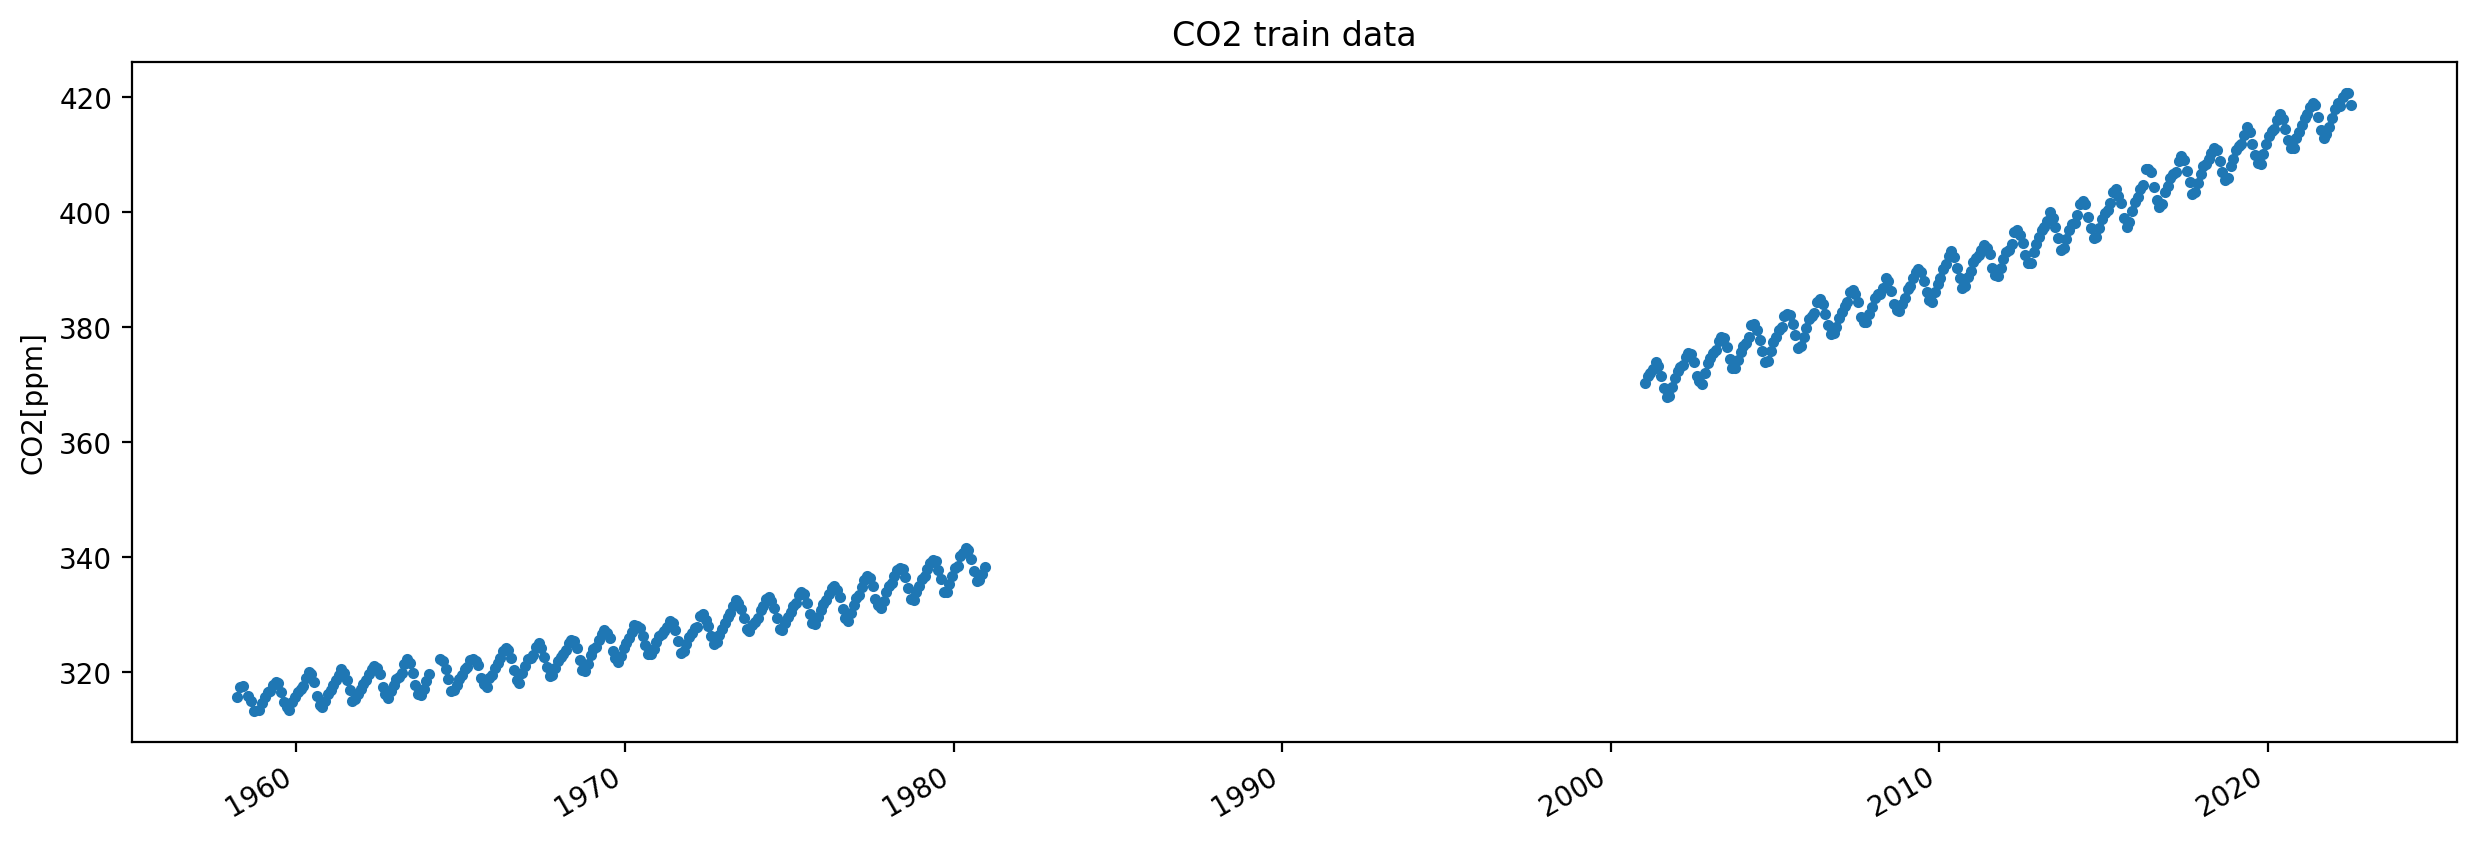

In [2]:
test_data = data.loc['1981':'2000', ['x', 'CO2']]  # We assume test data from 1981 to 2000 are unknown
train_data = data.loc[~data.index.isin(test_data.index), ['x', 'CO2']]  # We assume train data are known
train_data.CO2.plot(figsize=(15, 5), style='.', title="CO2 train data")
plt.ylabel('CO2[ppm]')

## Define Kernel functions

The code for `SE_kernel` and `white_noise_kernel` is given. **Please complete `periodic_kernel` and `linear_kernel`**.

In [3]:
def SE_kernel(x1, x2,  l2, s2=1):
    """Squared Exponential kernel
    ----------
    x1,x2: np.array, n by 1 input array
    l2: positive float, (length scale)^2
    s2: float, sigma^2
    """
    return s2*np.exp(-(x1.reshape([-1,1]) - x2.reshape([1,-1]))**2/l2)

def white_noise_kernel(x1, x2, e2=1):
    """White noise kernel
    ----------
    x1,x2: np.array, n by 1 input array
    e2: positive float, variance
    """
    if x1.shape == x2.shape:
        return e2*np.eye(x1.shape[0])
    else:
        raise ValueError("x1 and x2 should have the same shape")

def periodic_kernel(x1, x2, p, l2, s2=1):
    """Periodic kernel
    ----------
    x1,x2: np.array, n by 1 input array
    p: positive float, period
    l2: positive float, (length scale)^2
    s2: positive float, sigma^2
    """
    # Give your implementation here
    return s2*np.exp(-2/l2*np.sin(np.pi/p*np.abs(x1.reshape([-1,1]) - x2.reshape([1,-1])))**2)


def linear_kernel(x1, x2, c, s2=1):
    """Linear kernel (note we do not have a sigma_b^2 in this kernel)
    ----------
    x1,x2: np.array, n by 1 input array
    c: float, constant
    s2: float, sigma^2
    """
    # Give your implementation here
    
    return s2*(x1.reshape([-1,1])-c)*(x2.reshape([1,-1])-c)


In [4]:
def log_marginal_likelihood(x, y, kernel, kernel_params, e2):
    """Log marginal likelihood
    ----------
    x: np.array, n by 1 input array
    y: np.array, n by 1 output array
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance
    """
    K = kernel(x, x, kernel_params) + white_noise_kernel(x, x, e2)
    # Give your implementation here, you should use cholesky decomposition to improve speed.
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    lml = -0.5 * y.T.dot(alpha) - np.sum(np.log(np.diag(L))) - x.shape[0] / 2 * np.log(2 * np.pi)
    return lml


def prediction(X, y, X_star, kernel, kernel_params, e2):
    """Prediction
    ----------
    X: np.array, n by 1 input array at observed points
    y: np.array, n by 1 output array at observed points
    X_star: np.array, m by 1 input array at unknown points
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance
    
    return:
    -------
    mean: np.array, m by 1 mean of the predictive distribution
    covariances: np.array, m by m covariance matrix of the predictive distribution
    """
    K = kernel(X, X, kernel_params) + white_noise_kernel(X, X, e2)
    # Give your implementation here
    K_star = kernel(X_star, X, kernel_params)
    K_star_star = kernel(X_star, X_star, kernel_params)
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    v = solve(L, K_star.T)
    mean = K_star.dot(alpha)
    covariances = K_star_star - v.T.dot(v)
    return mean, covariances

## Using SE_kernel + noise
We first try to model the long range trend in CO2 by an SE kernel. You can see the results of using SE kernel after implementing the `log_marginal_likelihood` and `prediction` You don't have to complete any code in this section. 

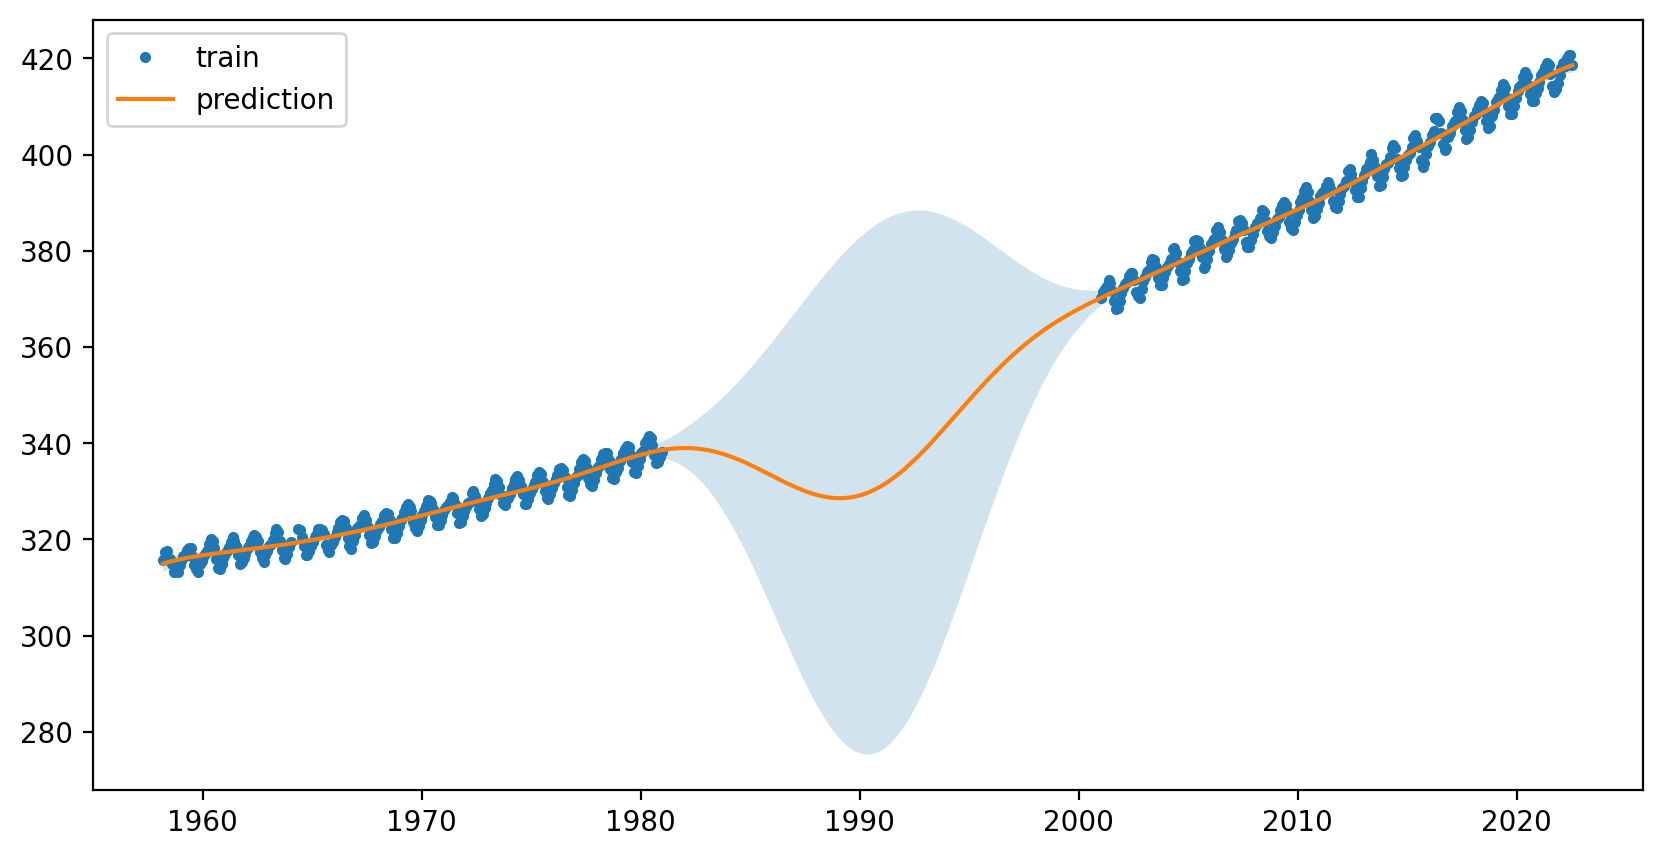

In [5]:
# Here are initial values for the kernel parameters
SE_l2_init = (12*10)**2  # The initial guess length scale of the SE kernel is 10 years (10*12 months)
SE_s2_init = 20
e2_init = 10


def kernel0(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. SE kernel.
    ----------
    x1,x2: np.array, n by 1 input array
    kernel_params: np.array, kernel parameters
    """
    SE_l2 = kernel_params[0]
    SE_s2 = kernel_params[1]
    return SE_kernel(x1, x2, l2=SE_l2, s2=SE_s2)


def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel0, kernel_params, e2)


# We use scipy minimize to optimize the negative log likelihood. 
# Note that we did not give the gradient information. So the optimization will be slow, around 30s.
res = minimize(NLL,
               x0=np.array([SE_l2_init, SE_s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((1e-5, None), (1e-5, None), (0.1, None)))  # bounds for the parameters


# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values, data.x.values, kernel0, res.x[:-1], res.x[-1])
data['y'] = y
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_data.CO2, '.',label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()


# Use Linear_kernel + noise
Similar to the previous section, **please use linear_kernel + noise to estimate the CO2. Plot the confidence interval of $\pm 2\sigma$**.
Some suggestion for initial hyperparameters: `c = 0`, `s2 = 1`. Note that `c` is unbounded. 

优化后的参数:
c (常数偏移): -1224.1251
s2 (方差参数): 205.6930
e2 (噪声方差): 1707.5111
负对数似然: 2543.9740


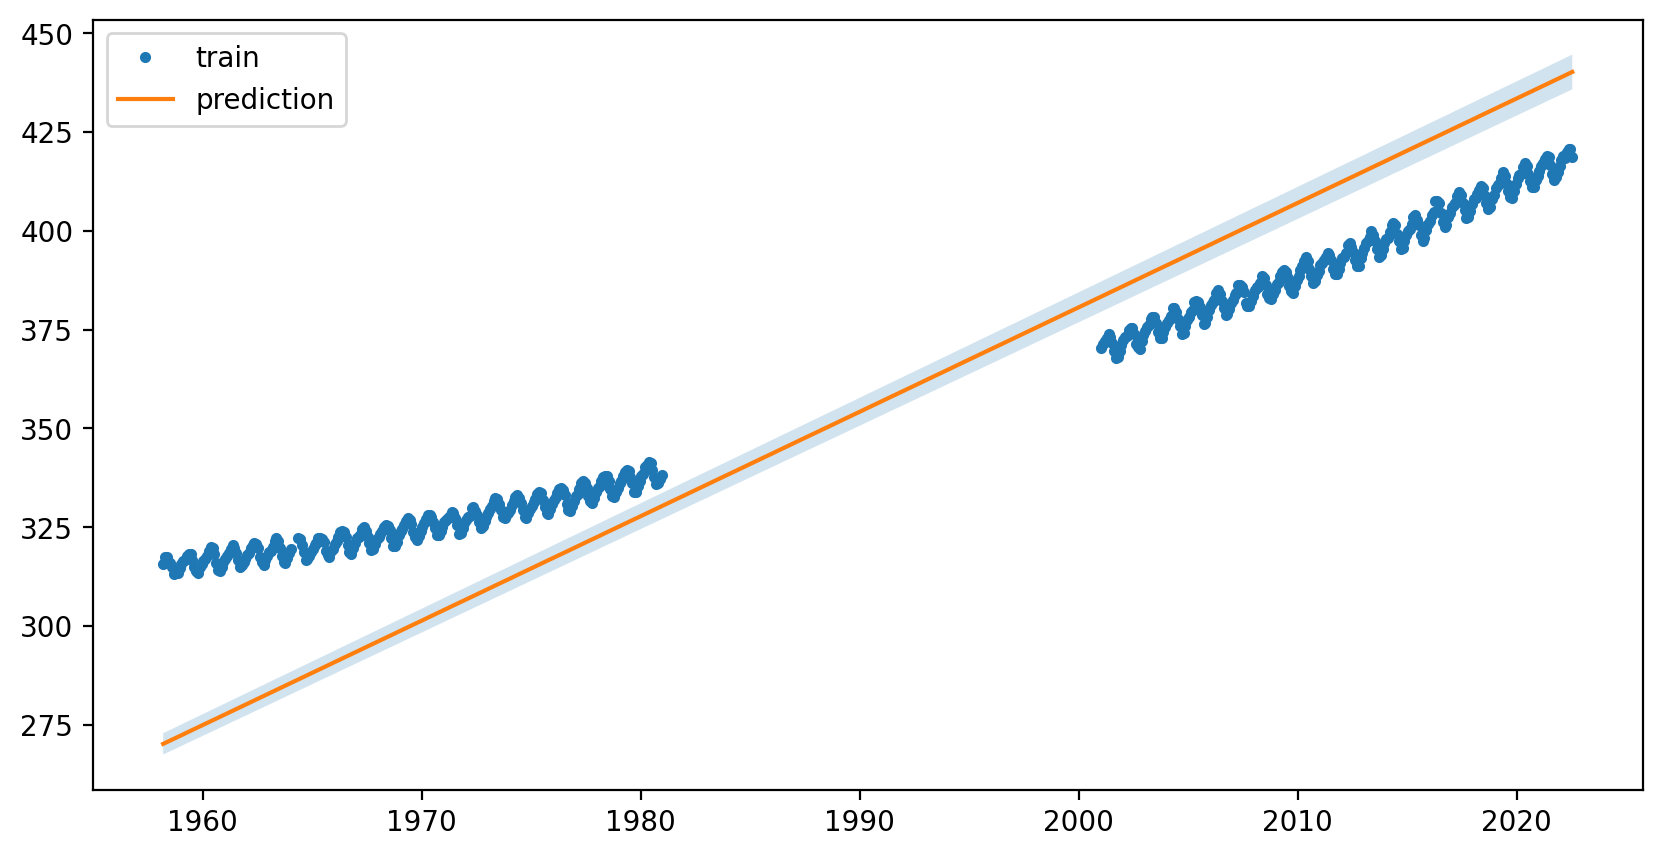

In [6]:
# Please give initial values for the kernel parameters
c_init=0
s2_init=1
e2_init = 10

def kernel1(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. Linear kernel."""
    # Give your implementation here for the linear kernel
    LK_c = kernel_params[0]
    LK_s2 = kernel_params[1]
    return linear_kernel(x1,x2,c=LK_c,s2=LK_s2)

# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel1, kernel_params, e2)


# We use scipy minimize to optimize the negative log likelihood. 

res = minimize(NLL,
               x0=np.array([c_init, s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((None, None), (1e-5, None), (0.1, None)))  # bounds for the parameters
print("优化后的参数:")
print(f"c (常数偏移): {res.x[0]:.4f}")
print(f"s2 (方差参数): {res.x[1]:.4f}")
print(f"e2 (噪声方差): {res.x[2]:.4f}")
print(f"负对数似然: {res.fun:.4f}")
# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values, data.x.values, kernel1, res.x[:-1], res.x[-1])
data['y'] = y
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_data.CO2, '.',label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()


# Use periodic_kernel + noise
Similar to the previous section, **please use periodic_kernel + noise to estimate the CO2. Plot the confidence interval of $\pm 2\sigma$**.
Some suggestion for initial hyperparameters:
- We can set `p=12` to reduce the number of hyperparameters that need to be optimized.

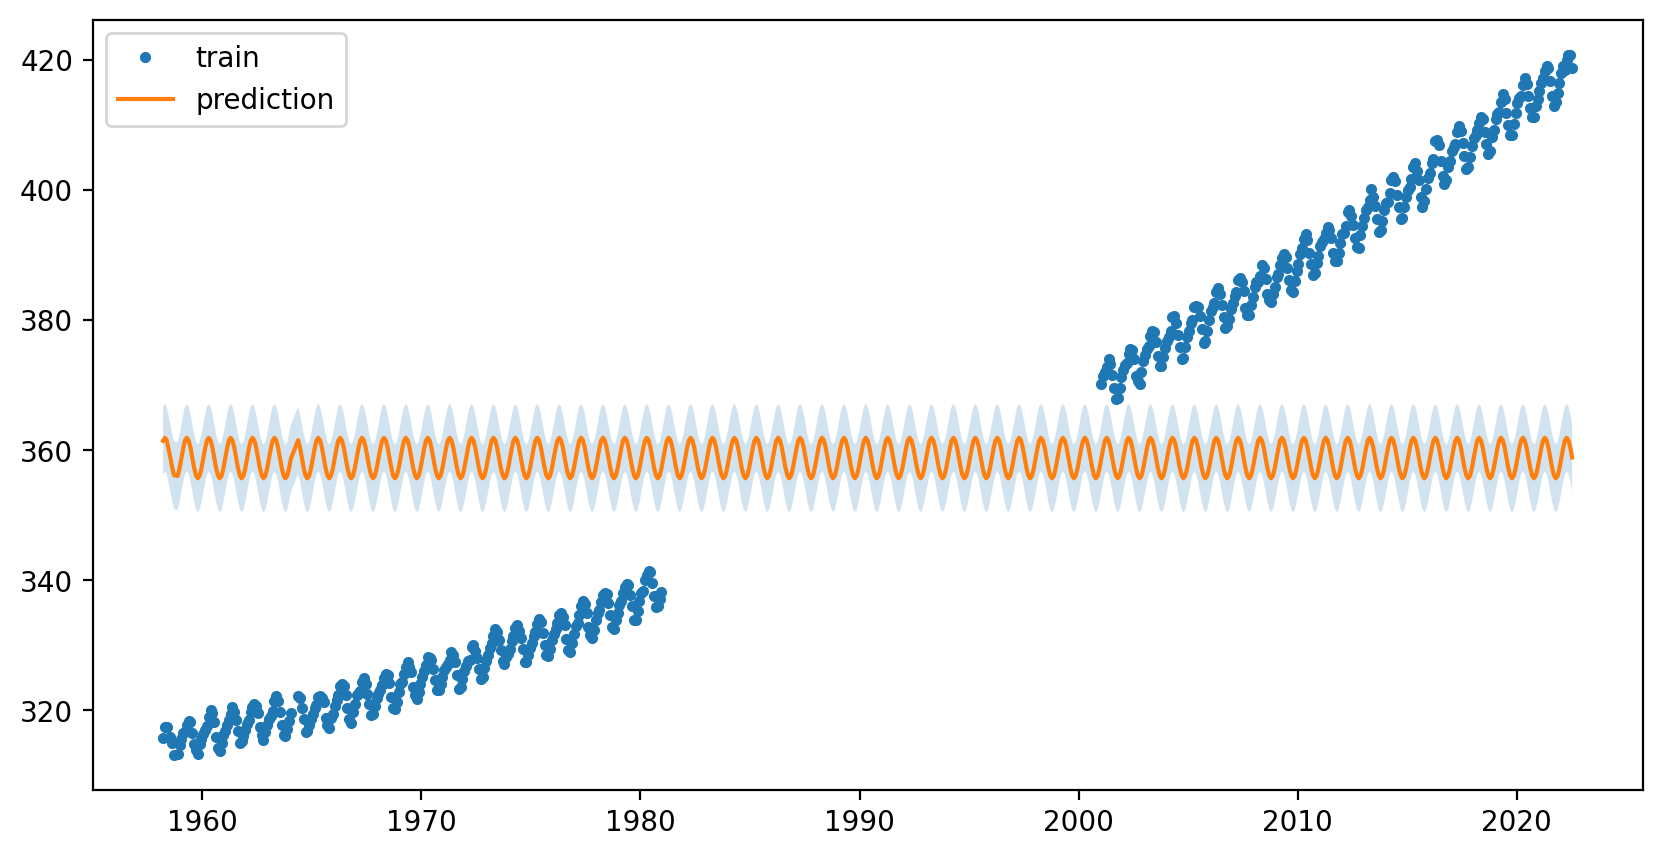

In [7]:
# Please give initial values for the kernel parameters
PK_p0=12
s2_init=1
l2_init = (1)**2  
e2_init = 10

def kernel2(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. Periodic kernel."""
    # please give your implementation here for the periodic kernel
    PK_l2 = kernel_params[0]
    PK_s2 = kernel_params[1]
    return periodic_kernel(x1, x2, p=PK_p0, l2=PK_l2, s2=PK_s2)


# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel2, kernel_params, e2)

res = minimize(NLL,
               x0=np.array([l2_init, s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((1e-5, None), (1e-5, None), (0.1, None)))  # bounds for the parameters

# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values, data.x.values, kernel2, res.x[:-1], res.x[-1])
data['y'] = y
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_data.CO2, '.',label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()


# Use linear_kernel + periodic_kernel + SE_kernel + noise
Similar to the previous section, **please use linear_kernel + periodic_kernel + SE_kernel + noise to estimate the CO2. Plot the confidence interval of $\pm 2\sigma$**.

In [8]:
# Please give initial values for the kernel parameters
PK_p0=12
s2_init=1
l2_init = (12*10)**2  
e2_init = 10
c_init=0
def kernel3(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. SE + Periodic + linear kernel."""
    # please give your implementation here for the SE + Periodic + linear kernel
    LK_c = kernel_params[0]
    LK_s2 = kernel_params[1]
    PK_l2 = kernel_params[2]
    PK_s2 = kernel_params[3]
    SE_l2 = kernel_params[4]
    SE_s2 = kernel_params[5]
    return linear_kernel(x1,x2,c=LK_c,s2=LK_s2)+\
            periodic_kernel(x1, x2, p=PK_p0, l2=PK_l2, s2=PK_s2)+\
            SE_kernel(x1, x2, l2=SE_l2, s2=SE_s2)


# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel3, kernel_params, e2)

res = minimize(NLL,
               x0=np.array([c_init,s2_init,l2_init,s2_init,l2_init,s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((None,None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (0.1, None)))  # bounds for the parameters

# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values,
                    data.x.values, kernel3, res.x[:-1], res.x[-1])
data['y'] = y
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_data.CO2, '.', label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()


LinAlgError: Matrix is not positive definite